# SAS Model Deployment Demo

- MAS Overview
- Setup
- Retrieving information about your models
- Scoring Data / Executing Decision with MAS

## MAS Overview
MAS is a memory-resident, high-performance program execution service, SAS Micro Analytic Service is multi-threaded and can be clustered for high availability. It can host multiple programs simultaneously, as well as multiple user or business contexts that are isolated from one another. It provides hosting for DS2 and Python programs and supports a “compile-once, execute-many-times” usage pattern.

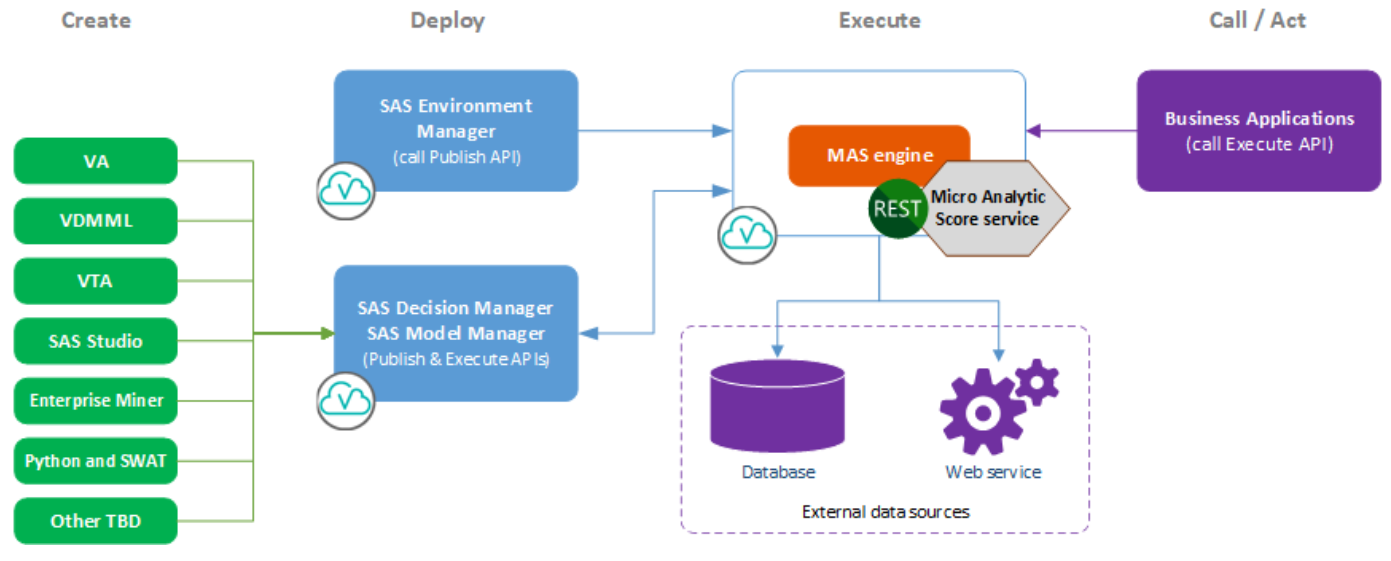

In [14]:
from IPython.display import Image
i = Image(filename = '/home/sasdemo/MAS_Workflow.PNG')

## Authentication -- optional step
If you have registered a client (see the authentication use case), uncomment the code below to generate an access token.

In [ ]:
 # import requests, json, base64
# sasserver = ""
# username = ""
# password = ""
# client_id = ""
# client_secret = ""
# url = sasserver + "/SASLogon/oauth/token"
# data = {
#     'grant_type': 'password',
#     'username': username,
#     'password': password
# }
# headers = {'Accept': 'application/json'}
# response = requests.post(url, headers=headers, data=data, auth=(client_id, client_secret), verify=False).json()
# access_token = response["access_token"]
# print("The access token is: " + access_token)

## Import modules, variable assignment
The first step of the process is to import the required packages and assign variable values.
Note: requests is the only library required to make API calls to MAS. The other imported libraries are specific to the code in this example).

In [1]:
import requests
import os, json
import pprint
import getpass
import pandas as pd

# Specify the URL for your host server
#Uncoment to dynamically retrieve your IP address
    #Assumption - you are working from a Linux machine  
#ip= os.popen("hostname -I").read()
#host = 'http://' + ip.split()[0]
host = ""
csv_data = "hmeq_test.csv"
access_token = ""

## Retrieving Information about Modules Deployed to your MAS server
Use the `/microanalyticScore/modules/` to retrieve metadata about the all of the modules deployed to MAS. A module represents program code and all the resources required to execute your model. 

In [ ]:
url =  host + "/microanalyticScore/modules/" 
headers = {
    'Accept': "application/vnd.sas.collection+json",
    'Authorization': "Bearer " + access_token
}
response = requests.request('GET', url, headers=headers, verify=False)
formatted_response = json.dumps(response.json(), indent=2)

## Format the output and display it using a pandas dataframe table

In [ ]:
df = pd.DataFrame.from_dict(json.loads(formatted_response)['items'])
df.drop(['links', 'properties','warnings'], axis = 1)

## Get the Inputs and Outputs of your Model/Decision
Use the `<model_id>/steps` endpoint to get the inputs and outputs of your `model/decision`.

In [ ]:
# Find your module and add its id to the model_id variable
model_id = ""
url =  host + "/microanalyticScore/modules/" + model_id + '/steps'
headers = {
    'Accept': "application/vnd.sas.collection+json",
    'Authorization': "Bearer " + access_token
}
response = requests.request('GET', url, headers=headers, verify=False)

#Retrieve the inputs and outpus from the last element of the 'items' json object 
inputs = json.loads(response.text)['items'][-1]['inputs']
outputs = json.loads(response.text)['items'][-1]['outputs']

## Print the inputs / outputs results

In [ ]:
print("Inputs:")
print(json.dumps(inputs, indent = 2))

In [ ]:
print("Outputs:")
print(json.dumps(outputs, indent = 2))

## Scoring Data

### Read in test data for scoring

In [ ]:
test_data = pd.read_csv(csv_data)
#convert test data colums to lowercase to match MAS input parameter names 
test_data.columns = map(str.lower, test_data.columns)
#Fill empty values with 0 
test_data = test_data.fillna(0)
test_data.head()

### Execute Decision
To execute a *decision*, use the `/steps/execute` endpoint. For *models* use the `/steps/score` endpoint. 

In [ ]:
import requests
import json
import random

url =  host + "/microanalyticScore/modules/" + model_id + '/steps/score'
headers = {
  'Authorization': "Bearer " + access_token,
  'Content-Type': "application/vnd.sas.microanalytic.module.step.input+json" 
}

#Build payload from test data
#Ex format: 
'''
'{"inputs": [
            {"name": "<input1_name>", "value": <decimal_value>}, \
            {"name": "<input2_name>", "value": "<string_value>"}, \
            ] }'
'''

#Retrieve values column values from file and dynamically build payload 
for i in range(len(test_data)): 
    row = test_data.iloc[i]
    payload = '{"inputs":[ ' 
    for i in range(len(inputs)):
        payload += '{ "name": ' 
        payload += '"' + inputs[i]['name']  + '"'
        payload += ', "value": '
        #Check if value input is decimal or character
        if inputs[i]['type'] == 'decimal':
            #Add underscore to column names to match MAS parameter format
            payload += str(row[(inputs[i]['name']).replace('_','')])
        #Add quotation marks around character input values
        else: 
           #Add underscore to column names to match MAS parameter format
            payload += '"' + str(row[(inputs[i]['name']).replace('_','')])+ '"'
        if i != (len(inputs) -1):
            payload += "},"
        else: 
            payload += "}"
    payload += "] }"
    
    

    #Send Request to MAS 
    r = requests.request("POST", url, data = payload, headers = headers, verify=False)
    
    #Print Formatted Request 
    formatted_response = json.dumps(r.json(), indent=2)
    print(formatted_response)


<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>
